# Astrometría 
#### Este notebook esta pensado para partir de una serie de imágenes sin infromación astrométrica y con ayuda de **SEXTRACTOR** y **Astrometry.net** encontrarles dicha solución y asignarselas al header de la imágen

Empezamos importando las librerías que utilizaremos.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
#from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, ZScaleInterval, LinearStretch
#from astropy.time import Time

from ccdproc import ImageFileCollection

#import subprocess
#import sys
import utilidades
#import os
#from IPython.display import clear_output

Vemos que hay en el directorio actual

In [2]:
ls

Astrometria.ipynb  default.param  Imagenes/      images_prop.dat  README.md
default.conv       default.sex    Imagenes_wcs/  __pycache__/     utilidades.py


Abrimos una imágen para inspeccionar de que se constituye

In [3]:
imagen_prueba = 'Imagenes/Vv0001.fit'
with fits.open(imagen_prueba) as hdul:
    hdul.info()
    hdr = hdul[0].header
    data = hdul[0].data

Filename: Imagenes/Vv0001.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   (1024, 1024)   int16 (rescales to uint16)   


### **Header**

In [4]:
hdr

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2019-10-04T20:22:25' / Date FITS file was generated                  
IRAF-TLM= '2019-10-04T20:24:11' / Time of last modification                     
OBJECT  = 'RVGRU   '           / Name of the object observed                    
CCDSIZE = '[1:1024,1:1024] '

### **Imagen**

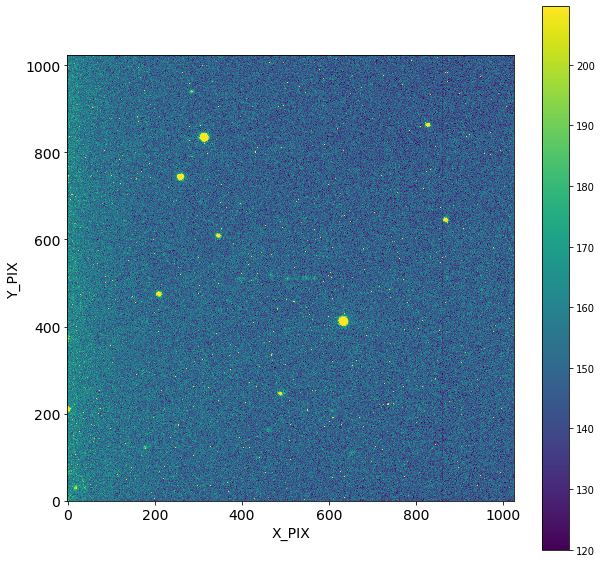

In [19]:
interval=ZScaleInterval()
vmin, vmax = interval.get_limits(data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10,10))

img = ax.imshow(data, origin='lower', norm=norm)
ax.set_xlabel('X_PIX', fontsize=14)
ax.set_ylabel('Y_PIX', fontsize=14)
ax.tick_params(labelsize=14)
plt.colorbar(img)
plt.show()

Los ejes son los números de pixel de la imagen

-------------

### La siguiente función genera un mapa de las imágenes dentro de un directorio usando los headers

In [5]:
carpeta = 'Imagenes/'
imagenes = ImageFileCollection(carpeta, keywords=['*'])

In [6]:
imagenes.summary[:3]

file,simple,bitpix,naxis,naxis1,naxis2,extend,bscale,bzero,origin,date,iraf-tlm,object,ccdsize,ccdsum,pixsize1,pixsize2,gain,rdnoise,camtem,exptime,observat,telescop,date-obs,time-obs,ut,st,ha,ra,dec,equinox,mjd-obs,zd,airmass,ra2000,dec2000,trk_frq,ha_prld,dec_prld,imagetyp,instrume,observer,prog-id,filter,epoch,jd,hjd,ljd,comment
str10,bool,int64,int64,int64,int64,bool,float64,float64,str37,str19,str19,str5,str15,str3,float64,float64,float64,float64,float64,float64,str6,str3,str10,str10,str10,str10,str11,str10,str11,float64,float64,float64,float64,str10,str11,float64,float64,float64,str6,str10,str25,str13,str5,float64,float64,float64,float64,str5
Vv0001.fit,True,16,2,1024,1024,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2019-10-04T20:22:25,2019-10-04T20:24:11,RVGRU,"[1:1024,1:1024]",1 1,24.0,24.0,2.2,15.0,-30.0,60.0,CASLEO,HSH,2019-09-30,00:43:28.0,00:43:28.0,20:40:14.8,-02:00:51.2,22:41:06.0,-46:47:21.3,2019.7,58756.030185,27.5,1.13,22:39:55.8,-46:53:33.6,59.99,495.0,699.0,object,Direct CCD,"Benvenuto, Blain, Ferrero",HS-2019B-DD01,(3) V,2019.7,2458756.53053241,2458756.53390004,2458756.0,= ' '
Vv0002.fit,True,16,2,1024,1024,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2019-10-04T20:22:25,2019-10-04T20:24:11,RVGRU,"[1:1024,1:1024]",1 1,24.0,24.0,2.2,15.0,-30.0,80.0,CASLEO,HSH,2019-09-30,00:46:44.8,00:46:44.8,20:43:32.1,-01:57:33.8,22:41:06.0,-46:47:21.3,2019.7,58756.032454,27.0,1.12,22:39:55.8,-46:53:33.6,59.99,495.0,699.0,object,Direct CCD,"Benvenuto, Blain, Ferrero",HS-2019B-DD01,(3) V,2019.7,2458756.53292593,2458756.53629342,2458756.0,= ' '
Vv0003.fit,True,16,2,1024,1024,False,1.0,32768.0,NOAO-IRAF FITS Image Kernel July 2003,2019-10-04T20:22:25,2019-10-04T20:24:11,RVGRU,"[1:1024,1:1024]",1 1,24.0,24.0,2.2,15.0,-30.0,80.0,CASLEO,HSH,2019-09-30,00:52:18.6,00:52:18.6,20:49:06.8,-01:51:58.8,22:41:05.6,-46:47:21.3,2019.7,58756.036319,26.1,1.11,22:39:55.4,-46:53:33.6,59.99,495.0,699.0,object,Direct CCD,"Benvenuto, Blain, Ferrero",HS-2019B-DD01,(3) V,2019.7,2458756.53678935,2458756.54015657,2458756.0,= ' '


Esta función definida en **utilidades.py**, toma todas las imágenes del directorio y les resuelve la astrometría utilizando **SEXTRACTOR** y **Astrometry.net**. Ademas genera una tabla (images_prop.dat) que tiene información sobre las imágenes.

Debemos conocer la escala de las imágenes y si queremos sobreescribir en un directorio usar la opción "forzar_escritura=True"

In [8]:
utilidades.Astrometria(imagenes,dir_salida='Imagenes_wcs/',escala=0.54, forzar_escritura=True)

Las nuevas imágenes con astrometría fueron guardadas en la carpeta Imagenes_wcs/


### Tabla de propiedades

In [9]:
img_prop = Table.read('images_prop.dat',format='ascii')
img_prop[:5]

fname,fwhm,fwhm_std,img_mean,img_std
str10,float64,float64,float64,float64
Vv0001.fit,8.242947578430176,0.8818293213844299,149.51683044433594,9.786988258361816
Vv0002.fit,9.319416999816895,1.8423517942428589,163.13035583496094,10.17916488647461
Vv0003.fit,9.275304794311523,1.5666587352752686,163.44015502929688,10.180580139160156
Vv0004.fit,9.693153381347656,0.5387027263641357,163.78746032714844,10.207042694091797
Vv0005.fit,8.568368911743164,1.4938238859176636,162.82373046875,10.160481452941895


Graficamos dicha tabla para ver el comportamiento de las imágenes.

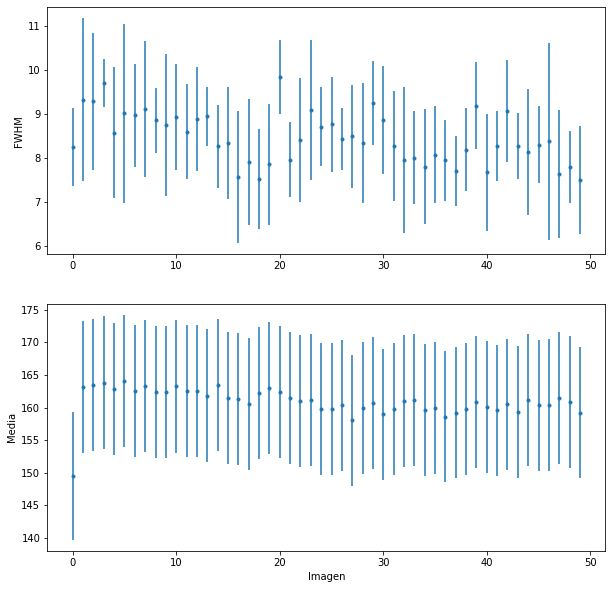

In [15]:
fig, (ax1,ax2)= plt.subplots(2,1, figsize=(10,10))
x=np.arange(0,img_prop['fname'].shape[0]) # arreglo de 0
ax1.errorbar(x=x,y='fwhm',
              yerr='fwhm_std',fmt='.',data=img_prop)
ax1.set(ylabel='FWHM')
ax2.errorbar(x=x,y='img_mean',
              yerr='img_std',fmt='.',data=img_prop)
ax2.set(ylabel='Media', xlabel='Imagen')
plt.show()

### Veamos como quedaron las nuevas imágenes

In [16]:
nueva = 'Imagenes_wcs/Vv0001w.fits'
with fits.open(nueva) as hdul:
    hdul.info()
    hdr = hdul[0].header
    data = hdul[0].data
    wcs = WCS(hdr)

Filename: Imagenes_wcs/Vv0001w.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     178   (1024, 1024)   int16 (rescales to uint16)   


In [17]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2019-10-04T20:22:25' / Date FITS file was generated                  
IRAF-TLM= '2019-10-04T20:24:11' / Time of last modification                     
OBJECT  = 'RVGRU   '           / Name of the object observed                    
CCDSIZE = '[1:1024,1:1024] '     / CCD size                                     
CCDSUM  = '1 1 '                 / CCD binning factors                          
PIXSIZE1=                 24.0   / pixel size for axis 1 (um)                   
PIXSIZE2=                 24

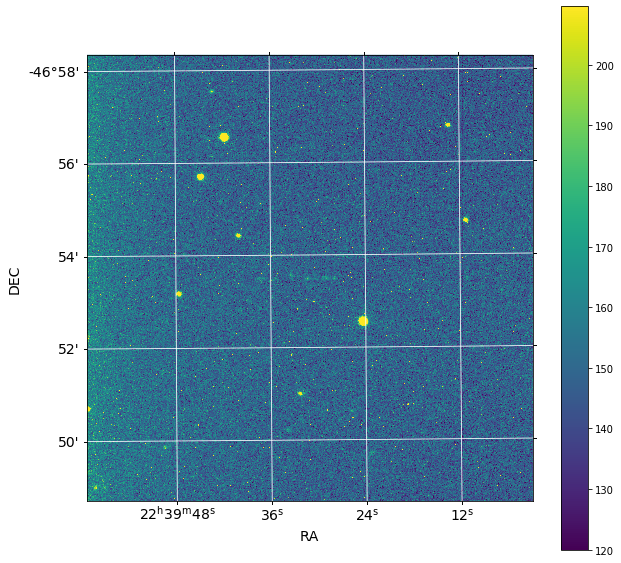

In [20]:
interval=ZScaleInterval()
vmin, vmax = interval.get_limits(data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10,10))
ax = plt.subplot(projection=wcs)
img = ax.imshow(data, origin='lower', norm=norm)
_ = plt.colorbar(img)
ax.grid(color='white', ls='solid')
ax.set_xlabel('RA', fontsize=14)
ax.set_ylabel('DEC', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylabel('DEC')